# Preliminaries

In [1]:
using PyCall
using PyPlot
using ForwardDiff
using DiffBase
using MAT

pygui(true)

import Base.convert
convert(::Type{Float64}, x::ForwardDiff.Dual) = Float64(x.value)
function convert(::Array{Float64}, x::Array{ForwardDiff.Dual}) 
    y = zeros(size(x)); 
    for i in 1:prod(size(x)) 
        y[i] = convert(Float64, x[i]) 
    end
    return y
end

include("hessian_utils.jl")

"""
We define functions to convert Duals, the variable types used by ForwardDiff, 
to Floats. This is useful if we want to print out the value of a variable 
(since print doesn't know how to Duals). Note that after being converted to a Float, no
differentiation by ForwardDiff can happen!  e.g. after
    x = convert(Float64, y)
ForwardDiff can still differentiate y, but it can't differentiate x
"""




"We define functions to convert Duals, the variable types used by ForwardDiff, \nto Floats. This is useful if we want to print out the value of a variable \n(since print doesn't know how to Duals). Note that after being converted to a Float, no\ndifferentiation by ForwardDiff can happen!  e.g. after\n    x = convert(Float64, y)\nForwardDiff can still differentiate y, but it can't differentiate x\n"

# Main dynamics function

In [2]:
function mgo_dynamics(;cue_period=500, delay_period=1000, response_period=500,
    const_E=15, theta=5, U_rest=-60, U_init=-51, Uth=-50, g_leak=1, response_extra_E=5, 
    nderivs=0, difforder=0, dt=5, tau=80, sigma=0.4, rule_input=0, w_self=0, w_other=-20,
    do_plot=false, plot_only_V = false, fignum=1)

    t = [0:dt:(cue_period+delay_period+response_period);]
    U = ForwardDiffZeros(2, length(t), nderivs=nderivs, difforder=difforder)
    V = ForwardDiffZeros(2, length(t), nderivs=nderivs, difforder=difforder)
    
    W = [w_self w_other ; w_other w_self]
    
    U[:,1] = U_init
    V[:,1] = 0.5*(1 + tanh((U[:,1]-Uth)/theta))
    
    for i in [2:length(t);]
        dUdt = W*V[:,i-1] + g_leak*(U_rest - U[:,i-1]) + const_E

        if t[i] < cue_period
            dUdt += [rule_input, -rule_input]''
        elseif t[i]>=cue_period + delay_period
            dUdt += response_extra_E
        end
        
        U[:,i] = U[:,i-1] + (dt/tau)*dUdt + sigma*randn(2,1)*sqrt(dt) 
        V[:,i] = 0.5*(1 + tanh((U[:,i]-Uth)/theta))
    end
    
    if do_plot
        figure(fignum)
        if !plot_only_V; subplot(2,1,1); end
        h = plot(t, V'); 
        setp(h[1], color=[0, 0, 1])
        setp(h[2], color=[1, 0, 0])
        ylabel("V")

        ax = gca()
        yl = [ylim()[1], ylim()[2]]
        vlines([cue_period, cue_period+delay_period], -0.05, 1.05, linewidth=2)
        if yl[1]<0.02; yl[1] = -0.02; end
        if yl[2]>0.98; yl[2] = 1.02;  end
        ylim(yl)
        grid(true)

        if ~plot_only_V
            subplot(2,1,2);
            h = plot(t, U'); 
            setp(h[1], color=[0, 0, 1])
            setp(h[2], color=[1, 0, 0])
            ylabel("U")

            ax = gca()
            yl = [ylim()[1], ylim()[2]]
            vlines([cue_period, cue_period+delay_period], yl[1], yl[2], linewidth=2)
            xlabel("t")
            grid(true)
        end
    end

    return t, U, V, W
end


figure(1); clf();
mgo_dynamics(do_plot=true, plot_only_V=true, const_E=15, sigma=0.4, dt=5, w_other=-20, rule_input=-0.25, response_extra_E=1)

([0,5,10,15,20,25,30,35,40,45  …  1955,1960,1965,1970,1975,1980,1985,1990,1995,2000],
[-51.0 -51.5027 … -41.5664 -40.1409; -51.0 -52.2959 … -65.2765 -65.1614],

[0.401312 0.354097 … 0.966864 0.980991; 0.401312 0.285289 … 0.00221432 0.00231836],

[0 -20; -20 0])

# Plot psychometric function

Done 1
Done 2


Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x32a12cc10>)


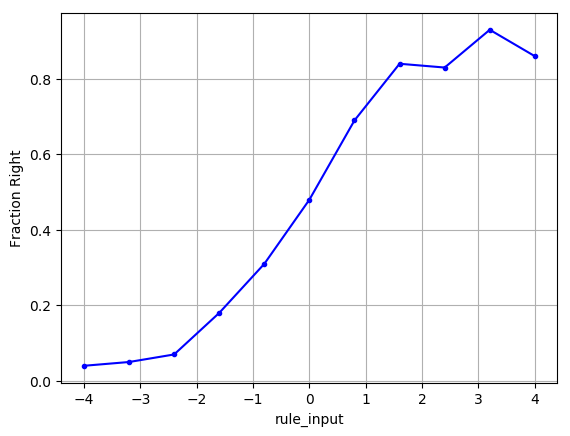

In [4]:
ntrials = 100
inputs = [-1:0.2:1;]*4
function psychometric(;ntrials=100, inputs=[-1:0.2:1;]*4, do_plot=false, pars...)
    fracright = zeros(size(inputs))
    wentright = zeros(1, ntrials)

    for input in [1:length(inputs);]
        for i in [1:ntrials;]
            outs = mgo_dynamics(;do_plot=do_plot, rule_input=inputs[input], pars...)[3][:,end]  # get the V matrix final point
            if outs[1] > outs[2]
                wentright[i] = 1
            else
                wentright[i] = 0
            end
            fracright[input] = mean(wentright)
            # @printf "     i: %d\n" i
        end
        @printf "Done %d\n" input
    end

    figure(2); clf();
    plot(inputs, fracright, "b.-")
    ylabel("Fraction Right")
    xlabel("rule_input")
    grid(true)
    println(figure(2))

    return  inputs, fracright
end;

psychometric(ntrials=ntrials, inputs=inputs, dt=5, sigma=0.4);

figure(1); clf();
for i in [1:10;]
    mgo_dynamics(do_plot=true, dt=5, sigma=0.4, rule_input=1.5)
end

figure(2)

# Cost function

In [5]:
function make_dict(args, x::Vector)
    kwargs = Dict();
    for i in [1:length(args);]
        kwargs = merge(kwargs, Dict(Symbol(args[i]) => x[i]))
    end
    return kwargs
end 

function Jcost(;target=0.8, ntrials=10, theta1=0.15, theta2=0.2, beta=0.05, seedrand = 300, verbose=true,
    rulestrength = 2, nderivs=0, difforder=0, do_plot=false, plot_trials=1, max_sigma=1, min_sigma=0.05, 
    params...)

    function sigma_cost(;max_sigma=1, min_sigma=0.05, sigma=0.5, params...)
        if sigma<max_sigma && min_sigma<sigma;
            return 0
        elseif max_sigma <= sigma
            return cosh((sigma-max_sigma)/0.1)-1.0
        elseif sigma <= min_sigma
            return cosh((min_sigma-sigma)/0.1)-1.0
        end
    end

    if !isnan(seedrand)
        srand(seedrand)
    else  # if the random seed is passed as NaN, use the system time in milliseconds
        srand(convert(Int64, round(1000*time())))
    end
    
    if isempty(size(plot_trials))
        plot_trials = [plot_trials]
    end;

    Vouts1 = ForwardDiffZeros(2, ntrials, nderivs=nderivs, difforder=difforder)
    Vouts2 = ForwardDiffZeros(2, ntrials, nderivs=nderivs, difforder=difforder)

    if do_plot; figure(1); clf(); subplot(2,1,1); end
    for i in [1:ntrials;]
        if do_plot && ~isempty(find(plot_trials.==i))
            Vouts1[:,i] = mgo_dynamics(;do_plot=true, plot_only_V=true, rule_input=rulestrength,  nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        else
            Vouts1[:,i] = mgo_dynamics(;rule_input=rulestrength,  nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        end
    end
    if do_plot; subplot(2,1,2); end
    for i in [1:ntrials;]
        if do_plot && ~isempty(find(plot_trials.==i))
            Vouts2[:,i] = mgo_dynamics(;do_plot=true, plot_only_V=true, rule_input=-rulestrength, nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        else
            Vouts2[:,i] = mgo_dynamics(;rule_input=-rulestrength, nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        end
    end
    
    hits1 = 0.5*(1 + tanh.((Vouts1[1,:]  - Vouts1[2,:])/theta1))
    hits2 = 0.5*(1 + tanh.((Vouts2[2,:]  - Vouts2[1,:])/theta1))
    hits  = [hits1 ; hits2]
    diffs1   = tanh((Vouts1[1,:]  - Vouts1[2,:]) /theta2).^2
    diffs2   = tanh((Vouts2[1,:]  - Vouts2[2,:]) /theta2).^2
    diffs = [diffs1 ; diffs2]
        
    cost1 = (mean(hits) - target)^2 
    cost2 = -mean(diffs) 
    
    if verbose
        @printf("                              cost1=%g, cost2=%g, mean(hits)=%.3f, mean(diffs)=%.3f\n", 
            convert(Float64, cost1), beta*convert(Float64, cost2), 
            convert(Float64, mean(hits)), convert(Float64, mean(diffs)))
    end
    
    if do_plot
        figure(2); clf();
        subplot(2,1,1)
        plot(1:2*ntrials, hits, "."); vlines(ntrials+0.5, ylim()[1], ylim()[2]) 
        xlim(-1, ntrials*2+1)
        title("hits")

        subplot(2,1,2)
        plot(1:2*ntrials, diffs, "."); vlines(ntrials+0.5, ylim()[1], ylim()[2]) 
        xlim(-1, ntrials*2+1)
        title("diffs")
    end
    
    return cost1 + beta*cost2 + sigma_cost(;max_sigma=max_sigma, min_sigma=min_sigma, params...), hits, diffs
end

cost, hits, diffs = Jcost(do_plot=true, plot_trials=[1:10;], sigma=0.4)
hits'

keyword_gradient((;pars...) -> Jcost(;do_plot=false, pars...)[1], ["sigma", "const_E"], [0.1, 1.2])

                              cost1=0.00249449, cost2=-0.049923, mean(hits)=0.750, mean(diffs)=0.998
                              cost1=0.0452278, cost2=-0.00259525, mean(hits)=0.587, mean(diffs)=0.052


2-element Array{Float64,1}:
 -0.371116 
 -0.0149961

# Minimal system optimization

### Plotting the system itself

In [6]:
figure(1); clf();
for i=[1:40;]
    mgo_dynamics(do_plot=true, dt=25, cue_period=200, delay_period=200, response_period=300, sigma=0.4, const_E=15, 
        w_self=0, w_other=-20, rule_input=2)
end

figure(2); clf();
psychometric(dt=25, cue_period=200, delay_period=200, response_period=300, sigma=0.4, 
const_E=15, w_self=0, w_other=-20, inputs=[-5:1:5;], ntrials=40)

Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 10
Done 11
PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x32a12cc10>)


([-5,-4,-3,-2,-1,0,1,2,3,4,5],[0.025,0.025,0.125,0.175,0.275,0.475,0.675,0.875,0.9,1.0,1.0])

In [7]:
Jcost(beta=0.05, rulestrength=2, ntrials=40,do_plot=true, plot_trials=[5,6,7,8,9], dt=25, sigma=0.7,
    cue_period=200, delay_period=200, response_period=300, const_E=15, w_self=0, w_other=-20)

                              cost1=0.0440213, cost2=-0.0466114, mean(hits)=0.590, mean(diffs)=0.932


(-0.002590163318211415,[0.999998,0.999998,0.00229818,0.0639038,5.96483e-6,0.316463,0.999997,0.999997,0.999997,0.999997  …  0.99556,0.999974,0.999998,0.999996,0.999981,0.999997,0.983838,0.999996,1.83421e-6,2.22352e-6],[0.999809,0.999811,0.958813,0.584251,0.999517,0.0789662,0.999707,0.999741,0.999677,0.999679  …  0.933291,0.998526,0.999761,0.999614,0.998833,0.999717,0.83221,0.999631,0.999801,0.99977])

### Now the minimization.

#### After some effort, looking pretty good! In the space of [const_E, w_self, w_other, sigma], can start from pretty arbitrary points and get good target % correct and nice-looking separation in output activity.

Some of the lessons learnt:

1. The cost function is doing ok. Narrow range for theta1 (hit/miss border) and a low beta=0.01, so that the diff measure only begins to matter once the cost function is doing good.
2. We need a boundary on sigma!  Too big and the simulations become unstable. Too small and see problem #3 immediately below. For MGO, "soft wall" boundaries of 0.05 and 0.6 were good.
3. We're really trying to operate on probability distributions-- if we could do Fokker-Planck, we would. So it is important that sigma not be too small (if sigma is too small, it corresponds in the Fokker-Planck world to small ball distributions, which might have no mass crossing the decision threshold and therefore no derivative with respect to log-likelihood for binary choice data).  
4. Similarly, we want the number of trials being run to be large-ish (n=200 seems ok for MGO?), so that we're covering the range of possible outputs and the probability distribution is reasonably represented. In particular, we want at least a few trials that end up near the decision border, even when we're near the final desired parameter values, since these are the trials that give us a not-too-small derivative magnitude. With n=1000, there seem to be enough trials near the decision border that things work ok. With smaller n, we could get idiosyncratically stuck.
5. In sum, put your resources into large # of trials and decent noise for reasonable representation of the probability distribution. Don't spend your resources on many unnecessary timesteps.
6. There are lots of local minima. So, we go for

And a general one for the simulations:

6. Adding sigma to U leads to better scaling w.r.t. dt than adding it to dUdt (because dUdt gets multiplied again by dt).  If we add it to U, then scaling by sqrt(dt) means very similar results for a wide range of dts.


# Final setup-- try different random starts and noisy trials if necessary

In [ ]:
args = ["const_E", "w_self", "w_other", "sigma", "rulestrength"]
bbox = [-20 20 ;
        -16 16 ; 
        -16 16 ; 
        0.05 0.6 ; 
        0.1  3]


ntrials =  200
max_attempts = 50
figure(4); clf();
nruns = 20
attempts_needed = zeros(1, nruns)
final_costs     = zeros(1, nruns)
randseeds       = zeros(Int64, 1, nruns)
final_params    = zeros(length(args), nruns)

for k in [1:nruns;]            
    local i
    local params
    local trajectory
    
    for i in [1:max_attempts;]                        
        randseeds[k] = convert(Int64, rem(round(time()*1e12), 1e6))
        
        
        func = (;pars...) -> Jcost(;beta=0.01, min_sigma=0.01, max_sigma=20, 
        rulestrength=2, ntrials=ntrials, seedrand=randseeds[k],    
            do_plot=false, plot_trials=[5,6,7,8,9], verbose=false, dt=25, 
            cue_period=200, delay_period=200, response_period=300,  
            pars...)[1]

        seed = rand(length(args),1)[:].*(bbox[:,2]-bbox[:,1]) + bbox[:,1]

        params, trajectory = bbox_Hessian_keyword_minimization(seed, args, bbox, func, hardbox=false,
            verbose=false, tol=1e-12, start_eta=1, wallwidth_factor=0.18);

        @printf "Attempt %d with seed %d ended with cost %g\n" i randseeds[k] trajectory[2,end]

        if trajectory[2,end] <= -0.005
            @printf "        ---success!\n"        
            break    
        end
    end

    
    final_params[:,k] = params
    final_costs[k] = trajectory[2,end]
    attempts_needed[k] = i
    @printf "\n---------- Finished run %d --------\n" k
end

matwrite("attempt_distribution.mat", Dict("attempts_needed" => attempts_needed, "ntrials"=>ntrials, 
"max_attempts" => max_attempts, "randseeds"=>randseeds, "final_costs"=>final_costs, "final_params"=>final_params,
"args"=>args, "bbox"=>bbox, "ntrials"=>ntrials))

figure(4); clf();
ax = gca();
ax[:hist](attempts_needed');
xlabel("no. of atempts needed")
ylabel("no. of runs")

In [ ]:

"""
macro   load_dict(D)    Use to load and assign all variables in a dictionary loaded by matread

EXAMPLE:

eval(@load_dict(matread("attempt_distribution.mat")))

"""
macro load_dict(U)
    quote
        local P = :(A=B;)
        for k in keys($(esc(U)))
            P.args[1].args[1] = Symbol(k)
            P.args[1].args[2] = $(esc(U))[k]
            P.args = [P.args[1:end]; copy(P.args[1])]
        end
        P.args = P.args[1:end-1]
        P
    end
end

eval(@load_dict(matread("attempt_distribution.mat")))

figure(4);
clf()
println(args)
plot(final_params[1,:], final_params[5,:], "o")

func = (;pars...) -> Jcost(;beta=0.01, min_sigma=0.01, max_sigma=20, 
    rulestrength=2, ntrials=ntrials, seedrand=randseeds[1],    
    do_plot=false, plot_trials=[5,6,7,8,9], verbose=false, dt=25, 
    cue_period=200, delay_period=200, response_period=300,  
    pars...)[1]

value, grad, hess = keyword_vgh(func, args, final_params[:,1])

eig((hess))[2]

### ---  end final setup ----

# Exploring automatic setting of hit and diff tanh widths

In [ ]:
function Jcost2(;target=0.8, ntrials=10, theta1=0.15, theta2=0.2, thetascale=0.8, beta=0.05, 
    seedrand = 300, verbose=true, rulestrength = 2, nderivs=0, difforder=0, do_plot=false, plot_trials=1, 
    params...)    
    
    if !isnan(seedrand)
        srand(seedrand)
    else  # if the random seed is passed as NaN, use the system time in milliseconds
        srand(convert(Int64, round(1000*time())))
    end
    
    if isempty(size(plot_trials))
        plot_trials = [plot_trials]
    end;

    Vouts1 = ForwardDiffZeros(2, ntrials, nderivs=nderivs, difforder=difforder)
    Vouts2 = ForwardDiffZeros(2, ntrials, nderivs=nderivs, difforder=difforder)

    if do_plot; figure(1); clf(); subplot(2,1,1); end
    for i in [1:ntrials;]
        if do_plot && ~isempty(find(plot_trials.==i))
            Vouts1[:,i] = mgo_dynamics(;do_plot=true, plot_only_V=true, rule_input=rulestrength,  nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        else
            Vouts1[:,i] = mgo_dynamics(;rule_input=rulestrength,  nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        end
    end
    if do_plot; subplot(2,1,2); end
    for i in [1:ntrials;]
        if do_plot && ~isempty(find(plot_trials.==i))
            Vouts2[:,i] = mgo_dynamics(;do_plot=true, plot_only_V=true, rule_input=-rulestrength, nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        else
            Vouts2[:,i] = mgo_dynamics(;rule_input=-rulestrength, nderivs=nderivs, difforder=difforder, params...)[3][:,end]
        end
    end
    
#    sdev1 = [Vouts1[1,:] - Vo]
    
    hits1 = 0.5*(1 + tanh.((Vouts1[1,:]  - Vouts1[2,:])/theta1))
    hits2 = 0.5*(1 + tanh.((Vouts2[2,:]  - Vouts2[1,:])/theta1))
    hits  = [hits1 ; hits2]
    diffs1   = tanh((Vouts1[1,:]  - Vouts1[2,:]) /theta2).^2
    diffs2   = tanh((Vouts2[1,:]  - Vouts2[2,:]) /theta2).^2
    diffs = [diffs1 ; diffs2]
        
    cost1 = (mean(hits) - target)^2 
    cost2 = -mean(diffs) 
    
    if verbose
        @printf("                              cost1=%g, cost2=%g, mean(hits)=%.3f, mean(diffs)=%.3f\n", 
            convert(Float64, cost1), beta*convert(Float64, cost2), 
            convert(Float64, mean(hits)), convert(Float64, mean(diffs)))
    end
    
    if do_plot
        figure(2); clf();
        subplot(2,1,1)
        plot(1:2*ntrials, hits, "."); vlines(ntrials+0.5, ylim()[1], ylim()[2]) 
        xlim(-1, ntrials*2+1)
        title("hits")

        subplot(2,1,2)
        plot(1:2*ntrials, diffs, "."); vlines(ntrials+0.5, ylim()[1], ylim()[2]) 
        xlim(-1, ntrials*2+1)
        title("diffs")
    end
    
    return cost1 + beta*cost2, hits, diffs, Vouts1, Vouts2
end

cost, hits, diffs, Vouts1, Vouts2 = Jcost2(do_plot=true, plot_trials=[1:10;], sigma=0.4)
hits'

keyword_gradient((;pars...) -> Jcost2(;do_plot=false, pars...)[1], ["sigma", "const_E"], [0.1, 1.2])

In [ ]:
cost, hits, diffs, Vouts1, Vouts2 = Jcost2(do_plot=true, plot_trials=1:10, ntrials=30, sigma=0.005, seedrand=200)
Z = [Vouts1[1,:] - Vouts1[2,:]; Vouts2[1,:] - Vouts2[2,:]]
sqrt(var(Z))
figure(3); clf();
plot(Z, ".")
tZ = tanh(Z/0.2).^2
plot(tZ, "r.")

g1 = keyword_gradient((;pars...) -> Jcost2(;do_plot=true, plot_trials=1:10, # theta1=1.5, theta2=2,
    ntrials=30, sigma=0.005, seedrand=200, pars...)[1], ["const_E"], [15])


In [ ]:
g2/g1

In [ ]:
args = ["const_E", "w_self", "w_other", "sigma", "rulestrength"]
bbox = [-200 200 ;
        -16 16 ; 
        -160 160 ; 
        0.0001 0.6 ; 
        0.1  3]

func = (;pars...) -> Jcost(;beta=0.01, min_sigma=0.01, max_sigma=20, 
    rulestrength=2, ntrials=ntrials, seedrand=220,    
    do_plot=false, plot_trials=[5,6,7,8,9], verbose=true, dt=25, 
    cue_period=200, delay_period=200, response_period=300,  
    pars...)[1]

seed = [50, 0, -60, 0.0001, 2]

params, trajectory = bbox_Hessian_keyword_minimization(seed, args, bbox, func, hardbox=false,
verbose=true, tol=1e-12, start_eta=1, wallwidth_factor=0.18)



In [ ]:
trajectory[2,end]